# Funciones

Requirements.txt
numpy==1.21.5
plotly==5.24.1
pickle

In [3]:
def do_schoolbook(f,g):
  n = len(f)
  m = len(g)
  C = [anillo(0)] * (n+m-1)
  for i in range(n):
    for j in range(m):
        C[i+j] = C[i+j] + f[i]*g[j]
  return C

def do_karatsuba(f,g, K_threshold=8):
  n = len(f)
  n0 = n //2
  n1 = n - n0
  if n < K_threshold:
    return do_schoolbook(f,g)
  f0 = f[:n0] # tamaño n0
  f1 = f[n0:]  # tamaño n1
  g0 = g[:n0] # tamaño n0
  g1 = g[n0:]  # tamaño n1
  u = do_karatsuba(f0,g0, K_threshold) # tamaño 2*n0-1
  v = do_karatsuba(f1,g1, K_threshold) # tamaño 2*n1-1
  # Usamos f1, g1 como f0+f1,g0+g1 para evitar crear más listas
  # Fijaos que n1 >= n0
  for i in range(n0):
    f1[i] = f1[i]+f0[i]
    g1[i] = g1[i]+g0[i]
  w = do_karatsuba(f1,g1, K_threshold) # tamaño 2*n1-1
  # resto u y v a w, el problema es que los tamaños pueden ser distintos
  for i in range(2*n0-1):
    w[i] = w[i] - u[i] - v[i]
  for i in range(2*n0-1,2*n1-1):
    w[i] = w[i] - v[i]
  #C = [0] * (2*n-1)
  #for i in range(2*n0-1):
  #  C[i] = C[i] + u[i]
  #  C[n0+i] = C[n0+i] + w[i]
  #  C[2*n0+i] = C[2*n0+i] + v[i]
  #for i in range(2*n0-1,2*n1-1):
  #  C[n0+i] = C[n0+i] + w[i]
  #  C[2*n0+i] = C[2*n0+i] + v[i]
  #
  # u contiene los monomios de 0 a 2*n0-2
  # v contiene los monomios de 2*n0 a 2*n-1
  # solo nos falta el monomio 2*n0-1
  # podemos usarlo para evitar sumas en C
  C = u +[anillo(0)] +v
  for i in range(2*n1-1):
    C[n0+i] = C[n0+i] + w[i]
  return C

def do_karatsuba_different_size(left: list, right: list, K_threshold: int=8) -> list:
    """
    Multiplicación de dos polinomios de diferente grado, usando una
    estrategia de división del polinómio mayor en partes de tamaño
    del polinomio menor. Así, poder aplicar do_karatsuba a las partes.

    INPUT:

    - ``left``  -- representación de polinomio como lista
    - ``right`` -- representación de polinomio como lista
    - ``K_threshold`` -- Entero, se usa como criterio para usar la 
    multiplicación de la escuela si el el grado de alguno de los 
    polinómios es menor que él.

    TESTS:

    sage: do_karatsuba_different_size([anillo(1), anillo(2)], [anillo(3), anillo(4)])  # Grados iguales
    [3, 10, 8]

    sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(4), anillo(5)])  # n > m
    [4, 13, 22, 15]

    sage: do_karatsuba_different_size([anillo(3), anillo(4)], [anillo(1), anillo(2), anillo(3)])  # n < m
    [3, 10, 17, 12]

    sage: do_karatsuba_different_size([], [anillo(1), anillo(2), anillo(3)])  # Caso vacío
    []

    sage: do_karatsuba_different_size([anillo(1)], [anillo(1), anillo(2), anillo(3)])  # Caso n = 1
    [1, 2, 3]

    sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(1)])  # Caso m = 1
    [1, 2, 3]

    sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(4), anillo(5)], K_threshold=1)  # Caso K_threshold bajo
    [4, 13, 22, 15]

    """
    n: int= len(left); m: int= len(right)
    if n == 0 or m == 0:
        return []
    if n == 1:
        c = left[0]
        return [c*a for a in right]
    if m == 1:
        c = right[0]
        return [a*c for a in left] # beware of noncommutative rings
    
    if n <= K_threshold or m <= K_threshold or K_threshold==1 or K_threshold==2:
        return do_schoolbook(left, right)
    if n == m:
        return do_karatsuba(left, right, K_threshold)
    if n > m:
        # left is the bigger list
        # n is the bigger number
        q = n // m
        r = n % m
        output = do_karatsuba(left[:m], right, K_threshold)
        for i in range(1, q): #from 1 <= i < q:
            mi = m*i
            carry = do_karatsuba(left[mi:mi+m], right, K_threshold)
            for j in range(m-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[m-1:])
        if r:
            mi = m*q
            carry = do_karatsuba_different_size(left[mi:], right, K_threshold)
            for j in range (m-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[m-1:])
        return output
    else:
        # n < m, I need to repeat the code due to the case
        # of noncommutative rings.
        q = m // n
        r = m % n
        output = do_karatsuba(left, right[:n], K_threshold)
        for i in range(1,q): #from 1 <= i < q:
            mi = n*i
            carry = do_karatsuba(left, right[mi:mi+n], K_threshold)
            for j in range(n-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[n-1:])
        if r:
            mi = n*q
            carry = do_karatsuba_different_size(left, right[mi:], K_threshold)
            for j in range(n-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[n-1:])
        return output



NUM_SUMA = 0
NUM_PRODUCTO = 0

class anillo:
    def __init__(self, valor):
        self.valor = valor

    def __repr__(self):
        return repr(self.valor)

    def __add__(self, otro):
        global NUM_SUMA 
        NUM_SUMA = NUM_SUMA + 1
        return anillo(self.valor + otro.valor)

    def __sub__(self,otro):
        global NUM_SUMA 
        NUM_SUMA = NUM_SUMA + 1
        return anillo(self.valor - otro.valor)

    def __mul__(self, otro):
        global NUM_PRODUCTO
        NUM_PRODUCTO = NUM_PRODUCTO + 1
        return anillo(self.valor * otro.valor)


# Ejercicio 1

Compare los métodos `do_karatsuba` y `do_schoolbook` vistos en clase para polinomios del mismo tamaño `n`.

- Construya sendas listas `L_K`, `L_S` tal que cada entrada sea un triplete `(i, n_p, n_o)` donde `i` sea el tamaño de los polinomios, `n_p` el número de productos que realiza cada algoritmo y `n_o` el número de operaciones totales (productos + sumas).

- Realice una representación gráfica del número de operaciones totales dependiendo del tamaño.

- Compruebe experimentalmente que `do_schoolbook` realiza $O(i^2)$ operaciones y `do_karatsuba` realiza $O(i^{\log_2(3)})$ operaciones.

- Experimente con el punto de corte (threshold) y comente sobre las gráficas resultantes para distintos puntos de corte.


## Generación de listas

In [1]:
import pickle


def generador_listas1(funcion, tamaño_max=100, card_cuerpo_finito=2, K_threshold=2, export_pkl=False, verbose=False):
    F=GF(card_cuerpo_finito)
    R=F['x']
    L=[]
    global NUM_SUMA, NUM_PRODUCTO 
    for i in range(tamaño_max+1):
        f = [anillo(R(1)) for t in range(i)]
        if funcion == 'do_karatsuba':
            NUM_SUMA = 0
            NUM_PRODUCTO = 0
            result=do_karatsuba(f, f, K_threshold=K_threshold)
            L.append((i, NUM_PRODUCTO, NUM_SUMA+NUM_PRODUCTO))
        elif funcion == 'do_schoolbook':
            NUM_SUMA = 0
            NUM_PRODUCTO = 0
            result=do_schoolbook(f, f)
            L.append((i, NUM_PRODUCTO, NUM_SUMA+NUM_PRODUCTO))
        else:
            raise ValueError('El valor de "funcion" debe ser "do_karatsuba" o "do_schoolbook"')
            break
        if verbose and i%50==0:
            print(i) 
    
    if export_pkl:
        if funcion == 'do_karatsuba':
            file_name = f'{funcion}_K({K_threshold})_{tamaño_max}.pkl'
        else:
            file_name = f'{funcion}_{tamaño_max}.pkl'
        if verbose:
            print(f'Exportando "{file_name}"...')
        with open(file_name, 'wb') as file:
            pickle.dump({'L': L}, file)
    return L

In [4]:
tamaño=150

L_K = generador_listas1(funcion = 'do_karatsuba',
                            tamaño_max=tamaño,
                            export_pkl=True,
                            verbose=True)
print(L_K)
L_S = generador_listas1(funcion = 'do_schoolbook',
                            tamaño_max=tamaño,
                            export_pkl=True,
                            verbose=True)
print(L_S)

0
50
100
150
Exportando "do_karatsuba_K(2)_150.pkl"...
[(0, 0, 0), (1, 1, 2), (2, 3, 11), (3, 7, 33), (4, 9, 46), (5, 17, 94), (6, 21, 120), (7, 25, 150), (8, 27, 167), (9, 43, 267), (10, 51, 319), (11, 59, 375), (12, 63, 405), (13, 71, 469), (14, 75, 503), (15, 79, 541), (16, 81, 562), (17, 113, 766), (18, 129, 870), (19, 145, 978), (20, 153, 1034), (21, 169, 1150), (22, 177, 1210), (23, 185, 1274), (24, 189, 1308), (25, 205, 1440), (26, 213, 1508), (27, 221, 1580), (28, 225, 1618), (29, 233, 1698), (30, 237, 1740), (31, 241, 1786), (32, 243, 1811), (33, 307, 2223), (34, 339, 2431), (35, 371, 2643), (36, 387, 2751), (37, 419, 2971), (38, 435, 3083), (39, 451, 3199), (40, 459, 3259), (41, 491, 3495), (42, 507, 3615), (43, 523, 3739), (44, 531, 3803), (45, 547, 3935), (46, 555, 4003), (47, 563, 4075), (48, 567, 4113), (49, 599, 4381), (50, 615, 4517), (51, 631, 4657), (52, 639, 4729), (53, 655, 4877), (54, 663, 4953), (55, 671, 5033), (56, 675, 5075), (57, 691, 5239), (58, 699, 5323), (

## Importación Archivos

In [28]:
import pickle

def importar_pkl(abrir_archivo):
    with open(abrir_archivo, 'rb') as file:
        data = pickle.load(file)
    return data['L']

abrir_archivo="do_schoolbook_150.pkl"
L_import=importar_pkl(abrir_archivo)
print(L_import)

[(0, 0, 0), (1, 1, 2), (2, 4, 8), (3, 9, 18), (4, 16, 32), (5, 25, 50), (6, 36, 72), (7, 49, 98), (8, 64, 128), (9, 81, 162), (10, 100, 200), (11, 121, 242), (12, 144, 288), (13, 169, 338), (14, 196, 392), (15, 225, 450), (16, 256, 512), (17, 289, 578), (18, 324, 648), (19, 361, 722), (20, 400, 800), (21, 441, 882), (22, 484, 968), (23, 529, 1058), (24, 576, 1152), (25, 625, 1250), (26, 676, 1352), (27, 729, 1458), (28, 784, 1568), (29, 841, 1682), (30, 900, 1800), (31, 961, 1922), (32, 1024, 2048), (33, 1089, 2178), (34, 1156, 2312), (35, 1225, 2450), (36, 1296, 2592), (37, 1369, 2738), (38, 1444, 2888), (39, 1521, 3042), (40, 1600, 3200), (41, 1681, 3362), (42, 1764, 3528), (43, 1849, 3698), (44, 1936, 3872), (45, 2025, 4050), (46, 2116, 4232), (47, 2209, 4418), (48, 2304, 4608), (49, 2401, 4802), (50, 2500, 5000), (51, 2601, 5202), (52, 2704, 5408), (53, 2809, 5618), (54, 2916, 5832), (55, 3025, 6050), (56, 3136, 6272), (57, 3249, 6498), (58, 3364, 6728), (59, 3481, 6962), (60, 3600

## Representación Gráfica

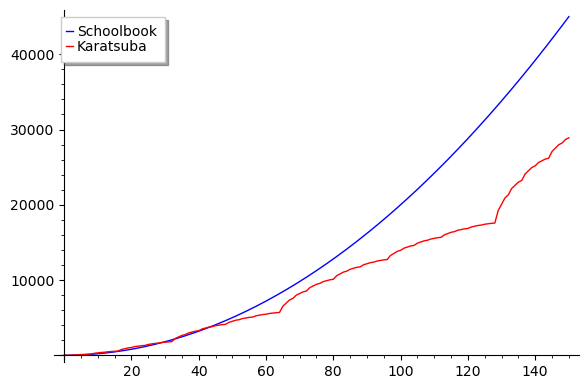

In [29]:
line([(foo[0], foo[2]) for foo in L_S], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in L_K], color='red', legend_label='Karatsuba')

## Comprobación experimental Ordenes

In [30]:
import numpy as np
import plotly.graph_objects as go

# Funciones de clase de complejidad
def O_schoolbook(n):
    """Calcula O(n^2)"""
    return n**2

def O_karatsuba(n):
    """Calcula O(n^log_2(3))"""
    return n**log(3,2)  # O(n^log2(3))

# Función para crear frames dinámicos
def crear_frames(dominio, clase_complejidad, valores_funcion, a_range, verbose=False):
    """Crea los frames para la animación."""
    frames = []
    total_steps = len(a_range)
    if verbose:
        print(f"Creando frames para {total_steps} valores...")

    for i, a in enumerate(a_range):
        if verbose and i % 10 == 0:  # Mostrar progreso cada 10 iteraciones
            print(f"Progreso: {i}/{total_steps} frames creados...")
        y = [a * val for val in clase_complejidad]
        frames.append(go.Frame(data=[
            go.Scatter(x=list(dominio), y=y, mode='lines', name=f"Clase Complejidad x {a:.1f}"),
            go.Scatter(x=list(dominio), y=valores_funcion, mode='lines', name="Schoolbook")
        ], name=str(a)))

    if verbose:
        print("Frames creados completamente.")
    return frames

# Función para configurar la figura inicial
def configurar_figura(dominio, clase_complejidad, valores_funcion, frames):
    """Configura la figura inicial y los botones interactivos."""
    fig = go.Figure(
        data=[
            go.Scatter(x=list(dominio), y=clase_complejidad, mode='lines', name="Clase Complejidad"),
            go.Scatter(x=list(dominio), y=valores_funcion, mode='lines', name="Función")
        ],
        layout=go.Layout(
            title="Comprobación experimental pertenencia de una Función a una clase de Complejidad",
            xaxis=dict(title="Tamaño Input (n)"),
            yaxis=dict(title="Número de operaciones"),
        ),
        frames=frames  # Asocia los frames a la figura
    )
    return fig

# Función para agregar el deslizador
def agregar_deslizador(fig, a_range):
    """Agrega un deslizador interactivo a la figura."""
    sliders = [dict(
        steps=[dict(method="animate",
                    args=[[str(a)], dict(mode="immediate",
                                         frame=dict(duration=100, redraw=True),
                                         transition=dict(duration=0))],
                    label=f"{a:.1f}") for a in a_range],
        transition=dict(duration=0),
        x=0.1,
        y=-0.2,
        currentvalue=dict(font=dict(size=15), prefix="a: ", visible=True, xanchor="center"),
        len=0.9
    )]
    fig.update_layout(sliders=sliders)

# Main: Orquestración de las funciónes anteriores
def pintar_con_deslizador(funcion, clase_complejidad, deslizador=np.linspace(0.1, 13.1, 100), verbose=False):
    if verbose:
        print("Iniciando generación de la visualización...")
    dominio = range(len(funcion))

    if verbose:
        print(f"Tamaño del dominio: {len(dominio)-1} elementos.")
        print("Generando frames...")
    frames = crear_frames(dominio, clase_complejidad, funcion, deslizador, verbose=verbose)

    if verbose:
        print("Configurando figura...")
    fig = configurar_figura(dominio, clase_complejidad, funcion, frames)

    if verbose:
        print("Agregando deslizador...")
    agregar_deslizador(fig, deslizador)

    if verbose:
        print("Mostrando figura interactiva...")
    fig.show()



### `do_schoolbook` $\in O(i^2)$ operaciones

In [ ]:
O_n2 = [O_schoolbook(n) for n in range(len(L_S))]
valores_funcion = [i[2] for i in L_S]

pintar_con_deslizador(   funcion=valores_funcion, 
                        clase_complejidad=O_n2, 
                        deslizador=np.linspace(0, 4.1, 40),
                        verbose = True)
# 1s aprox

Iniciando generación de la visualización...
Tamaño del dominio: 150 elementos.
Generando frames...
Creando frames para 40 valores...
Progreso: 0/40 frames creados...
Progreso: 10/40 frames creados...
Progreso: 20/40 frames creados...
Progreso: 30/40 frames creados...
Frames creados completamente.
Configurando figura...
Agregando deslizador...
Mostrando figura interactiva...


### `do_karatsuba` $\in O(i^{\log_2(3)})$

In [ ]:
O_nlog_23 = [O_karatsuba(n) for n in range(len(L_K))]
valores_funcion = [i[2] for i in L_K]

pintar_con_deslizador(   funcion=valores_funcion, 
                        clase_complejidad=O_nlog_23, 
                        deslizador=np.linspace(6, 13.1, 35),
                        verbose= True)
# 2mins aprox ¿porque? no lo entiendo, se lo piensa mucho para mostrar la figura

Iniciando generación de la visualización...
Tamaño del dominio: 150 elementos.
Generando frames...
Creando frames para 35 valores...
Progreso: 0/35 frames creados...
Progreso: 10/35 frames creados...
Progreso: 20/35 frames creados...
Progreso: 30/35 frames creados...
Frames creados completamente.
Configurando figura...
Agregando deslizador...
Mostrando figura interactiva...


## Experimentación Threshold

In [40]:
import numpy as np
import plotly.graph_objects as go

def crear_frames_threshold(tam_poli, threshold_range, verbose=False):
    """Crea los frames para graficar listas con el deslizador de threshold."""
    frames = []
    cantidad_thresholds = len(threshold_range)-1
    if verbose:
        print(f"Creando frames para {cantidad_thresholds} valores de threshold...")

    y_s = generador_listas1(funcion='do_schoolbook', tamaño_max=tam_poli)
    x = list(range(tam_poli))
    for i, threshold in enumerate(threshold_range,2):
        if verbose and i % 10 == 0:  # Mostrar progreso cada 10 iteraciones
            print(f"Progreso: {i}/{cantidad_thresholds} frames creados...")
        
        # Calculamos la lsita para cada threshold
        y_k = generador_listas1(funcion='do_karatsuba', tamaño_max=tam_poli, K_threshold=threshold)
                
        frames.append(go.Frame(data=[
            go.Scatter(x=x, y=[n[2] for n in y_k], mode='lines', name=f"Karatsuba"),
            go.Scatter(x=x, y=[n[2] for n in y_s], mode='lines', name=f"Schoolbook")
        ], name=str(threshold)))
    
    if verbose:
        print("Frames creados completamente.")
    return frames

def configurar_figura_threshold(threshold_range, frames, ancho=800, alto=600):
    """Configura la figura inicial para graficar listas con threshold."""
    fig = go.Figure(
        data=frames[0].data,
        layout=go.Layout(
            title="Gráfica de listas valores_karatsuba y valores_schoolbook con filtro de threshold",
            xaxis=dict(title="Tamaño Polinomios"),
            yaxis=dict(title="Número de Operaciones"),

        ),
        frames=frames
    )
    return fig

def agregar_deslizador_threshold(fig, threshold_range):
    """Agrega un deslizador para controlar el threshold."""
    sliders = [dict(
        steps=[dict(method="animate",
                    args=[[str(threshold)], dict(mode="immediate",
                                                 frame=dict(duration=100, redraw=True),
                                                 transition=dict(duration=0))],
                    label=f"{threshold:.1f}") for threshold in threshold_range],
        transition=dict(duration=0),
        x=0.1,
        y=-0.2,
        currentvalue=dict(font=dict(size=15), prefix="threshold: ", visible=True, xanchor="center"),
        len=0.9
    )]
    fig.update_layout(sliders=sliders)

def graficar_listas_threshold(tam_poli=60, max_threshold_range=40, verbose=False):
    """Grafica las listas valores_karatsuba y valores_schoolbook con un deslizador para el threshold."""
    if verbose:
        print("Iniciando generación de la visualización...")
    if verbose:
        print(f"Tamaño de los polinomios: {tam_poli}")
        print("Generando frames...")
    
    # Crear frames
    threshold_range=np.linspace(2, max_threshold_range, max_threshold_range-1)
    frames = crear_frames_threshold(tam_poli, threshold_range, verbose=verbose)

    if verbose:
        print("Configurando figura...")
    fig = configurar_figura_threshold(threshold_range, frames)

    if verbose:
        print("Agregando deslizador...")
    agregar_deslizador_threshold(fig, threshold_range)

    if verbose:
        print("Mostrando figura interactiva...")
    fig.show()


In [43]:
graficar_listas_threshold(tam_poli=150, 
                        max_threshold_range=40, 
                        verbose=True)

# 50s aprox

Iniciando generación de la visualización...
Tamaño de los polinomios: 150
Generando frames...
Creando frames para 38 valores de threshold...
Progreso: 10/38 frames creados...
Progreso: 20/38 frames creados...
Progreso: 30/38 frames creados...
Progreso: 40/38 frames creados...
Frames creados completamente.
Configurando figura...
Agregando deslizador...
Mostrando figura interactiva...


### Versión manual con SAGE
Se ven mejor los picos


In [ ]:
l_k, l_s = generador_listas1(tamaño_max=90, 
                            card_cuerpo_finito=2,
                            K_threshold=4,
                            verbose=True)
line([(foo[0], foo[2]) for foo in l_s], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in l_k], color='red', legend_label='Karatsuba')

In [ ]:
l_k, l_s = generador_listas1(tamaño_max=90, 
                            card_cuerpo_finito=2,
                            K_threshold=8,
                            verbose=True)
line([(foo[0], foo[2]) for foo in l_s], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in l_k], color='red', legend_label='Karatsuba')

In [ ]:
l_k, l_s = generador_listas1(tamaño_max=90, 
                            card_cuerpo_finito=2,
                            K_threshold=16,
                            verbose=True)
line([(foo[0], foo[2]) for foo in l_s], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in l_k], color='red', legend_label='Karatsuba')

In [ ]:
l_k, l_s = generador_listas(tamaño_max=90, 
                            card_cuerpo_finito=2,
                            K_threshold=32,
                            verbose=True)
line([(foo[0], foo[2]) for foo in l_s], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in l_k], color='red', legend_label='Karatsuba')

# Ejercicio 2

- Realice las mismas tareas que en el ejercicio anterior comparando `do_schoolbook` y la propuesta vista en clase de `do_karatsuba_different_size` para un polinomio $f$ de tamaño 1024 y un polinomio $g$ de tamaño variable $i$. Para esto considere un punto de corte de 8.

- Calcule para qué tamaños $i$ de $g$ nos encontramos con máximos locales que verifiquen:

$$
\text{NUM\_TOTAL}(1024, i) = \max\{\text{NUM\_TOTAL}(1024, k) : 1 \leq k \leq i\}
$$

$$
\exists j > i, \text{NUM\_TOTAL}(1024, j) < \text{NUM\_TOTAL}(1024, i)
$$

- Trate de modificar el código de `do_karatsuba_different_size` para que el tamaño de $g$ sea siempre un múltiplo de 8 añadiendo, si es preciso, ceros a la lista que representa $g$. ¿Cómo queda la gráfica con esta modificación? ¿Se ha mejorado? ¿A qué cree que se debe?


## Replicación ejercicio 1

In [55]:
import pickle


def generador_listas2(funcion, tamaño_max=100, card_cuerpo_finito=2, K_threshold=8, export_pkl=False, verbose=False):
    F=GF(card_cuerpo_finito)
    R=F['x']
    L=[]
    g = [anillo(R(1))]*1024
    global NUM_SUMA, NUM_PRODUCTO 
    for i in range(tamaño_max+1):
        f = [anillo(R(1)) for t in range(i)]
        if funcion == 'do_karatsuba_different_size':
            NUM_SUMA = 0
            NUM_PRODUCTO = 0
            result=do_karatsuba_different_size(f, g, K_threshold=K_threshold)
            L.append((i, NUM_PRODUCTO, NUM_SUMA+NUM_PRODUCTO))
        elif funcion == 'do_schoolbook':
            NUM_SUMA = 0
            NUM_PRODUCTO = 0
            result=do_schoolbook(f, g)
            L.append((i, NUM_PRODUCTO, NUM_SUMA+NUM_PRODUCTO))
        else:
            raise ValueError('El valor de "funcion" debe ser "do_karatsuba_different_size" o "do_schoolbook"')
            break
        if verbose and i%50==0:
            print(i) 
    
    if export_pkl:
        if funcion == 'do_karatsuba_different_size':
            file_name = f'{funcion}_K({K_threshold})_{tamaño_max}.pkl'
        else:
            file_name = f'{funcion}_different_size_{tamaño_max}.pkl'
        if verbose:
            print(f'Exportando "{file_name}"...')
        with open(file_name, 'wb') as file:
            pickle.dump({'L': L}, file)
    return L

In [58]:
L_K_DIFF= generador_listas2(funcion= 'do_karatsuba_different_size',
                            tamaño_max=150, 
                            card_cuerpo_finito=2,
                            K_threshold=8,
                            export_pkl=False,
                            verbose=True)

print(L_K_DIFF)

L_S_DIFF= generador_listas2(funcion= 'do_schoolbook',
                            tamaño_max=150, 
                            card_cuerpo_finito=2,
                            K_threshold=8,
                            export_pkl=False,
                            verbose=True)
print(L_S_DIFF)

0
50
100
150
[(0, 0, 0), (1, 1024, 1024), (2, 2048, 4096), (3, 3072, 6144), (4, 4096, 8192), (5, 5120, 10240), (6, 6144, 12288), (7, 7168, 14336), (8, 8192, 16384), (9, 7521, 19675), (10, 7690, 20072), (11, 9032, 22796), (12, 9228, 23216), (13, 10557, 25918), (14, 10759, 26336), (15, 9920, 28612), (16, 9216, 28849), (17, 10868, 32296), (18, 11264, 33051), (19, 11662, 33994), (20, 11555, 33667), (21, 13136, 36995), (22, 13589, 37814), (23, 13988, 38720), (24, 13880, 38465), (25, 15388, 41563), (26, 15888, 42515), (27, 16262, 43370), (28, 16176, 43191), (29, 15511, 45985), (30, 14910, 46514), (31, 14320, 47155), (32, 13824, 46817), (33, 15657, 50780), (34, 16336, 52052), (35, 16974, 53414), (36, 16984, 53334), (37, 17614, 54735), (38, 17514, 54584), (39, 17616, 54824), (40, 17471, 54356), (41, 19027, 57710), (42, 19791, 59298), (43, 20429, 60546), (44, 20499, 60486), (45, 21016, 61938), (46, 21077, 61860), (47, 21106, 62106), (48, 20844, 61482), (49, 22613, 65046), (50, 23256, 66334), (5

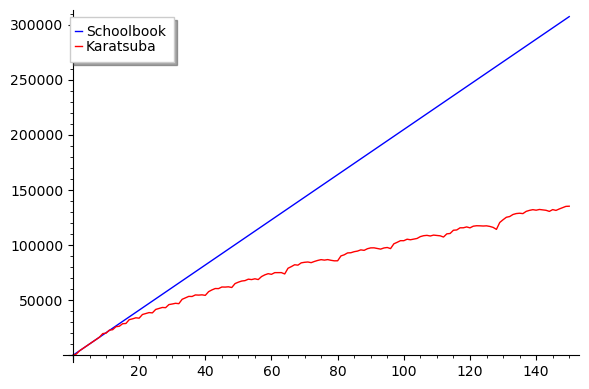

In [59]:
line([(foo[0], foo[2]) for foo in L_S_DIFF], color='blue', legend_label='Schoolbook') + line([(foo[0], foo[2]) for foo in L_K_DIFF], color='red', legend_label='Karatsuba')


## Calcular tamaños de i que cumplan la condición

In [ ]:
def encontrar_maximos_locales(L):
    maximos_locales = []
    max_actual = 0
    
    # Primero, identificar los puntos donde NUM_TOTAL es el máximo hasta ese punto
    for i, _, num_total in L:
        if num_total > max_actual:
            max_actual = num_total
            maximos_locales.append((i, num_total))
    
    # Ahora, filtrar aquellos máximos que tienen al menos un j > i con NUM_TOTAL(j) < NUM_TOTAL(i)
    maximos_finales = []
    for idx, (i, num_total_i) in enumerate(maximos_locales):
        # Verificar si existe algún j > i con NUM_TOTAL(j) < NUM_TOTAL(i)
        existe_decremento = False
        for j, _, num_total_j in L:
            if j > i and num_total_j < num_total_i:
                existe_decremento = True
                break
        if existe_decremento:
            maximos_finales.append((i, num_total_i))
    
    
    
    
    for j, _, num_total_j in L[i:]:
        # Verificar si existe algún j > i con NUM_TOTAL(j) < NUM_TOTAL(i)
            if num_total_j < num_total_i:
                maximos_locales.append((i, num_total_i))
                break
    return maximos_locales
    
    
    
    
    
    return maximos_finales

# Aplicar la función a L_K y L_S
maximos_K = encontrar_maximos_locales(l_k)

# Mostrar los resultados
print("Máximos locales para Karatsuba (L_K):")
for i, total in maximos_K:
    print(f"i = {i}, NUM_TOTAL = {total}")



## Modificación do_karatsuba_different_size tamaño g multiplo de 8

In [10]:
def do_karatsuba_different_size_mult_8(left: list, right: list, K_threshold: int=8) -> list:
    """
        Multiplicación de dos polinomios de diferente grado, usando una
        estrategia de división del polinómio mayor en partes de tamaño
        del polinomio menor. Así, poder aplicar do_karatsuba a las partes.

        INPUT:

        - ``left``  -- representación de polinomio como lista
        - ``right`` -- representación de polinomio como lista
        - ``K_threshold`` -- Entero, se usa como criterio para usar la 
        multiplicación de la escuela si el el grado de alguno de los 
        polinómios es menor que él.

        TESTS:

        sage: do_karatsuba_different_size([anillo(1), anillo(2)], [anillo(3), anillo(4)])  # Grados iguales
        [3, 10, 8]

        sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(4), anillo(5)])  # n > m
        [4, 13, 22, 15]

        sage: do_karatsuba_different_size([anillo(3), anillo(4)], [anillo(1), anillo(2), anillo(3)])  # n < m
        [3, 10, 17, 12]

        sage: do_karatsuba_different_size([], [anillo(1), anillo(2), anillo(3)])  # Caso vacío
        []

        sage: do_karatsuba_different_size([anillo(1)], [anillo(1), anillo(2), anillo(3)])  # Caso n = 1
        [1, 2, 3]

        sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(1)])  # Caso m = 1
        [1, 2, 3]

        sage: do_karatsuba_different_size([anillo(1), anillo(2), anillo(3)], [anillo(4), anillo(5)], K_threshold=1)  # Caso K_threshold bajo
        [4, 13, 22, 15]

    """
    n: int= len(left); m: int= len(right)
    if n == 0 or m == 0:
        return []
    if n == 1:
        c = left[0]
        return [c*a for a in right]
    if m == 1:
        c = right[0]
        return [a*c for a in left] # beware of noncommutative rings
    
    if n <= K_threshold or m <= K_threshold or K_threshold==1 or K_threshold==2:
        return do_schoolbook(left, right)
    if n == m:
        return do_karatsuba(left, right, K_threshold)

    # probablemnte sea mas eficiente ir sumando unos hasta qeu sea multiplo de 8
    if n % 8 !=0:
        n_prima = ((n+7)//8) * 8
        left = left + [anillo(0)]*(n_prima-n)
        n=n_prima
    if n > m:
        # left is the bigger list
        # n is the bigger number
        q = n // m
        r = n % m
        output = do_karatsuba(left[:m], right, K_threshold)
        for i in range(1, q): #from 1 <= i < q:
            mi = m*i
            carry = do_karatsuba(left[mi:mi+m], right, K_threshold)
            for j in range(m-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[m-1:])
        if r:
            mi = m*q
            carry = do_karatsuba_different_size(left[mi:], right, K_threshold)
            for j in range (m-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[m-1:])
        return output
    else:
        # n < m, I need to repeat the code due to the case
        # of noncommutative rings.
        q = m // n
        r = m % n
        output = do_karatsuba(left, right[:n], K_threshold)
        for i in range(1,q): #from 1 <= i < q:
            mi = n*i
            carry = do_karatsuba(left, right[mi:mi+n], K_threshold)
            for j in range(n-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[n-1:])
        if r:
            mi = n*q
            carry = do_karatsuba_different_size(left, right[mi:], K_threshold)
            for j in range(n-1):
                output[mi+j] = output[mi+j] + carry[j]
            output.extend(carry[n-1:])
        return output

In [71]:
def multiplo_mayor(g):
    return ((g+7)// 8) * 8


In [ ]:
R=GF(2)
A=[]
B8=[]
g=[anillo(R(1))]*1024
tam=1100
for i in range(tam+1):
    f = [anillo(R(1)) for t in range(i)]

    NUM_SUMA = 0
    NUM_PRODUCTO = 0
    h=do_karatsuba_different_size_mult_8(f, g, K_threshold=8)
    B8.append((i,NUM_SUMA,NUM_SUMA+NUM_PRODUCTO))
    if i%50 == 0:
        print(i)

In [ ]:
# print([(foo[0], foo[1]) for foo in A])
# print([(foo[0], foo[1]) for foo in B])
line([(foo[0], foo[2]) for foo in B8], color='blue', legend_label='K8') + line([(foo[0], foo[2]) for foo in B[:len(B8)]], color='red', legend_label='Karatsuba')



-------------

In [ ]:
R=GF(2)
A=[]
B=[]
g=[anillo(R(1))]*1024
tam=500
for i in range(tam+1):
    f = [anillo(R(1)) for t in range(i)]

    NUM_SUMA = 0
    NUM_PRODUCTO = 0
    h=do_karatsuba_different_size(f, g, K_threshold=8)
    B.append((i,NUM_SUMA,NUM_SUMA+NUM_PRODUCTO))
    if i%50 == 0:
        print(i)

In [ ]:
# print([(foo[0], foo[1]) for foo in A])
# print([(foo[0], foo[1]) for foo in B])
line([(foo[0], foo[2]) for foo in l_kt], color='blue', legend_label='K8') + line([(foo[0], foo[2]) for foo in l_k], color='red', legend_label='Karatsuba')



In [2]:
import pickle
def importar_pkl(abrir_archivo):
    with open(abrir_archivo, 'rb') as file:
        data = pickle.load(file)
    return data['L']

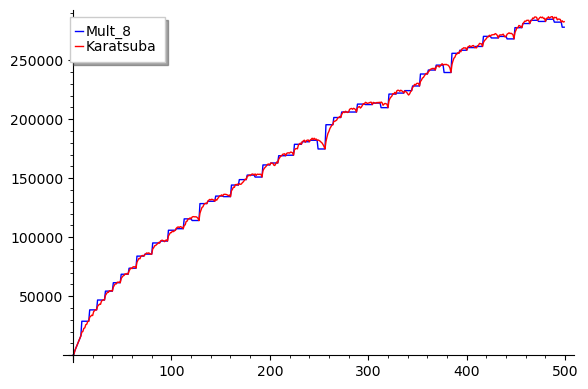

In [3]:
# importamos datos

L_K_DIFF=importar_pkl("do_karatsuba_different_size_K(8)_2048.pkl")
L_K_MULT=importar_pkl("do_karatsuba_different_size_mult_8_K(8)_2048.pkl")

TAMAÑO=500
line([(foo[0], foo[2]) for foo in L_K_MULT[:TAMAÑO]], color='blue', legend_label='Mult_8') + line([(foo[0], foo[2]) for foo in L_K_DIFF[:TAMAÑO]], color='red', legend_label='Karatsuba')

